In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
ds = xr.open_mfdataset(["data/GFM_global_NASA1km_2018slr_rp0100.nc", "data/GFM_global_NASA1km_2050slr_rp0100.nc"], 
                         combine="nested", concat_dim="time")

# Fix the coordinate lables per file
ds = ds.assign_coords(time=np.array([np.datetime64("2018-01-01"), np.datetime64("2050-01-01")]))
ds

<xarray.Dataset>
Dimensions:     (lat: 15660, lon: 38880, time: 2)
Coordinates:
  * time        (time) datetime64[ns] 2018-01-01 2050-01-01
  * lat         (lat) float64 -60.0 -59.99 -59.98 -59.97 ... 84.98 84.99 84.99
  * lon         (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    projection  (time) |S1 b'' b''
    inun        (time, lat, lon) float32 dask.array<chunksize=(1, 15660, 38880), meta=np.ndarray>
Attributes:
    source:       Global Tide and Surge Model v3.0 - ERA5
    institution:  Deltares
    title:        GFM - NASA 1km - 2018 slr - 0100-year return level
    references:   https://www.deltares.nl/en/
    Conventions:  CF-1.6
    project:      Microsoft Planetary Computer - Global Flood Maps
    config_file:  /p/temp/global/NASA1km_newWaterMask_noData/run_rp0100_slr20...
    history:      Created by: $Id: coastal_inun.py 528 2018-06-19 08:41:05Z e...

In [3]:
from shapely.geometry import shape

nola_geojson = {

        "type": "Polygon",
        "coordinates": [
          [
            [-91.730, 29.123],
            [-89.296, 29.123],
            [-89.296, 30.045],
            [-91.730, 30.045],
            [-91.730, 29.123]
          ]
        ]
    }

sfl_geojson = {
        "type": "Polygon",
        "coordinates": [
          [
            [-82.11181640625, 24.467150664739002],
            [-79.69482421875, 24.467150664739002],
            [-79.69482421875, 26.31311263768267],
            [-82.11181640625, 26.31311263768267],
            [-82.11181640625, 24.467150664739002]
          ]
        ]
      }

sfl_geojson_1 = {
        "type": "Polygon",
        "coordinates": [
          [
            [-82.2271728515625,25.854280326572407],
            [-81.1834716796875,25.854280326572407],
            [-81.1834716796875,26.534479888888043],
            [-82.2271728515625,26.534479888888043],
            [-82.2271728515625,25.854280326572407]
          ]
        ]
      }

poly = shape(sfl_geojson_1)
minx, miny, maxx, maxy = poly.bounds

#### Crop the array to a specified geo-area
- If I wanted a non-bbox polygon, would I have to rasterize a vector and do a mask?

In [4]:
ds = ds.sel(lat=slice(miny, maxy), lon=slice(minx, maxx))

In [5]:
# Check comapre mean inun each year
print(ds.isel(time=0)["inun"].mean().compute())
print(ds.isel(time=1)["inun"].mean().compute())


<xarray.DataArray 'inun' ()>
array(0.49357435, dtype=float32)
Coordinates:
    time     datetime64[ns] 2018-01-01
<xarray.DataArray 'inun' ()>
array(0.66501975, dtype=float32)
Coordinates:
    time     datetime64[ns] 2050-01-01


#### Visualize the coastal inundation

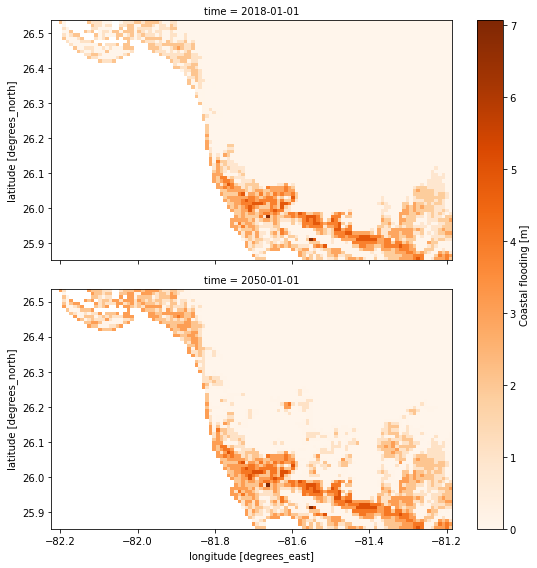

In [6]:
ds.inun.plot(col="time", col_wrap=1, figsize=(8,8), cmap="Oranges")

#### Distribution of inundation amount

Text(0.5, 1.0, '2050 100yr return')


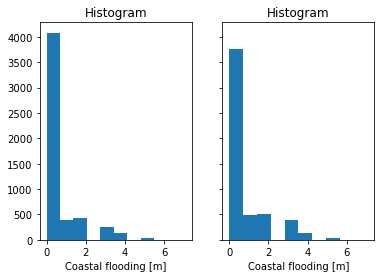

In [7]:
fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True)

# Can't set title?
axes[0].title.set_text("2018 100yr return")
axes[1].set_title("2050 100yr return")
print(axes[1].title)

ds.inun.sel(time="2018").plot.hist(ax=axes[0])
ds.inun.sel(time="2050").plot.hist(ax=axes[1])

plt.show()

#### Select only inundated area


In [71]:
flooded = ds.where(ds.inun > 0)
flooded

<xarray.Dataset>
Dimensions:     (lat: 74, lon: 112, time: 2)
Coordinates:
  * time        (time) datetime64[ns] 2018-01-01 2050-01-01
  * lat         (lat) float64 25.86 25.87 25.87 25.88 ... 26.5 26.51 26.52 26.53
  * lon         (lon) float64 -82.22 -82.21 -82.2 -82.19 ... -81.21 -81.2 -81.19
Data variables:
    projection  (time, lat, lon) object dask.array<chunksize=(1, 74, 112), meta=np.ndarray>
    inun        (time, lat, lon) float32 dask.array<chunksize=(1, 74, 112), meta=np.ndarray>
Attributes:
    source:       Global Tide and Surge Model v3.0 - ERA5
    institution:  Deltares
    title:        GFM - NASA 1km - 2018 slr - 0100-year return level
    references:   https://www.deltares.nl/en/
    Conventions:  CF-1.6
    project:      Microsoft Planetary Computer - Global Flood Maps
    config_file:  /p/temp/global/NASA1km_newWaterMask_noData/run_rp0100_slr20...
    history:      Created by: $Id: coastal_inun.py 528 2018-06-19 08:41:05Z e...

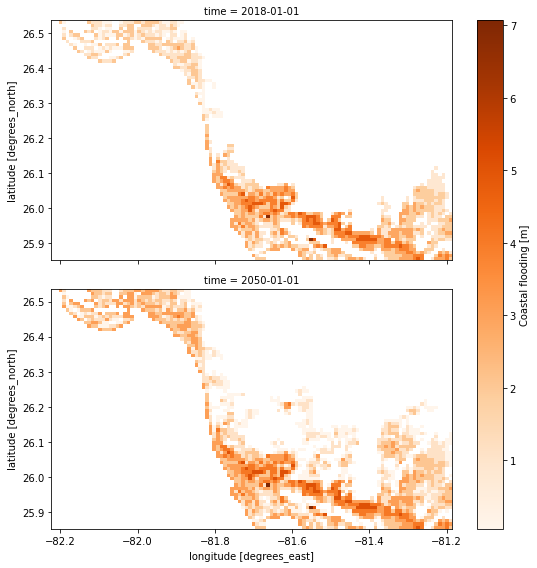

In [72]:
#flooded.inun.isel(time=0).plot()
flooded.inun.plot(col="time", col_wrap=1, figsize=(8,8), cmap="Oranges")

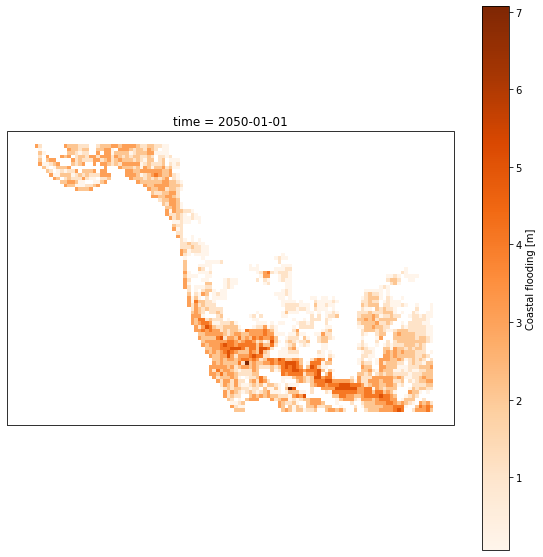

In [73]:
import cartopy.crs as ccrs

fig, axis = plt.subplots(
    1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()),
    figsize=(10,10)
)

flooded.inun.sel(time="2050").plot(
    ax=axis,
    transform=ccrs.PlateCarree(),
    cmap="Oranges"
)

#### Plot predicted raise > 1m by 2050

In [90]:
a = flooded["inun"].isel(time=0)
b = flooded["inun"].isel(time=1)

diff = b - a



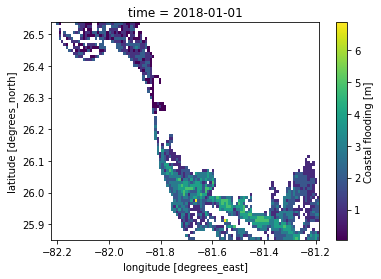

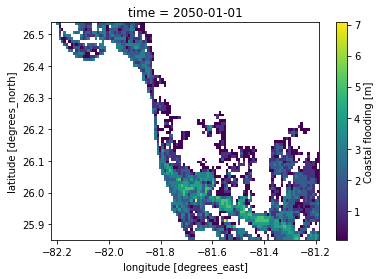

[[       nan        nan        nan ... 0.20378447 0.2037847  0.20378447]
 [       nan        nan        nan ... 0.20378447 0.2037847  0.20378447]
 [       nan        nan        nan ... 0.20378447 0.20378447 0.20378447]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan 1.0166171  ...        nan        nan        nan]]


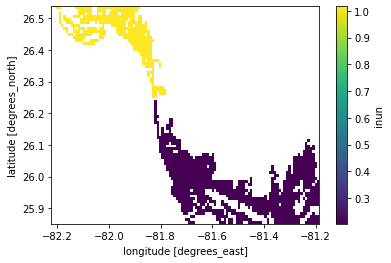

In [91]:
fig, axis = plt.subplots(nrows=2, ncols=1)

a.plot()
plt.show()
b.plot()
plt.show()
print(diff.values)

inun_diff = diff.where(diff > 0)
inun_diff.plot()
plt.show()
# fig, axis = plt.subplots(
#     1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()),
#     figsize=(10,10)
# )

# diff.plot(
#     ax=axis,
#     transform=ccrs.PlateCarree(),
#     cmap="coolwarm"
# )

# axis.coastlines(color="black", linewidth=1)